# Actor-critic methods

In recitation, we saw how to train a simple RL agent using policy gradients. In this notebook, we will train a more sophisticated agent for the [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment using an actor-critic method called [A3C].

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [4]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 7.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 61.2.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-3.9
      creating build/lib.macosx-10.9-x86_64-3.9/Box2D
      copying library/Box2D/Box2D.py -> build/lib.macosx-10.9-x86_64-3.9/Box2D
      copying library/Box2D/__init__.py -> build/lib.macosx-10.9-x86_64-3.9/Box2D
      creating build/lib.macosx-10.9-x86_64-3.9/Box2D/b2
      copying library/Box2D/b2/__init__.py -> build/lib.macosx-10.9-x86_64-3.9/Box2D/b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D/Box2D.i to Box2D/Box2D_wrap.cpp
      swig -python -c++ -IBox2D -small -O -includeall -ignoremissing -

In [3]:
train_env = gym.make('LunarLander-v2')
test_env = gym.make('LunarLander-v2')

DependencyNotInstalled: box2D is not installed, run `pip install gym[box2d]`

In [4]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.double()
        
    def forward(self, x):
        x = self.net(x)
        return x

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = test_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [ ]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [ ]:
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        state = state.double()

        action_pred = actor(state)
        value_pred = critic(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [ ]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [ ]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):
        
    advantages = advantages.detach()
    returns = returns.detach()
        
    policy_loss = - (advantages * log_prob_actions).sum()
    
    value_loss = F.smooth_l1_loss(returns, values).sum()
        
    optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    optimizer.step()
    
    return policy_loss.item(), value_loss.item()

In [ ]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        state = state.double()

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [ ]:
MAX_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 20

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:  20 | Mean Train Rewards:  -184.7 | Mean Test Rewards:  -644.4 |
| Episode:  40 | Mean Train Rewards:  -156.4 | Mean Test Rewards:  -952.2 |
| Episode:  60 | Mean Train Rewards:  -138.1 | Mean Test Rewards:  -816.8 |
| Episode:  80 | Mean Train Rewards:  -146.9 | Mean Test Rewards:  -935.8 |
| Episode: 100 | Mean Train Rewards:  -141.5 | Mean Test Rewards: -1163.4 |
| Episode: 120 | Mean Train Rewards:  -126.6 | Mean Test Rewards: -1079.4 |
| Episode: 140 | Mean Train Rewards:  -147.8 | Mean Test Rewards: -1147.9 |
| Episode: 160 | Mean Train Rewards:  -172.8 | Mean Test Rewards: -1078.6 |
| Episode: 180 | Mean Train Rewards:  -174.7 | Mean Test Rewards: -1055.2 |
| Episode: 200 | Mean Train Rewards:  -115.5 | Mean Test Rewards: -2748.8 |
| Episode: 220 | Mean Train Rewards:   -91.9 | Mean Test Rewards: -1681.5 |
| Episode: 240 | Mean Train Rewards:  -115.9 | Mean Test Rewards:  -542.6 |
| Episode: 260 | Mean Train Rewards:   -71.6 | Mean Test Rewards: -1233.9 |
| Episode: 2

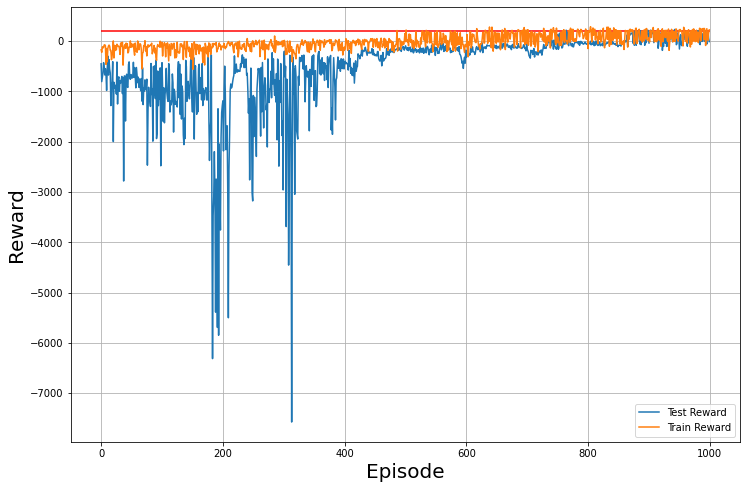

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()